In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!pip install pyspark

In [4]:
from pyspark.sql import SparkSession

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

import os

In [5]:
os.chdir('/gdrive/MyDrive/Dacon/Iris')

In [6]:
spark = (SparkSession
        .builder
        .appName('recommender_system')
        .getOrCreate())

In [7]:
train = spark.read.csv(os.getcwd() + '/Dataset/iris_train.csv',
                       inferSchema=True, header=True)

test = spark.read.csv(os.getcwd() + '/Dataset/iris_test.csv',
                      inferSchema=True, header=True)

In [8]:
train.summary().show()

+-------+-----------------+---------+------------------+------------------+-------------------+------------------+
|summary|               id|  species| sepal length (cm)| petal length (cm)|   sepal width (cm)|  petal width (cm)|
+-------+-----------------+---------+------------------+------------------+-------------------+------------------+
|  count|               75|       75|                75|                75|                 75|                75|
|   mean|             37.0|     null|6.0440000000000005|4.2586666666666675| 2.9586666666666672|             1.384|
| stddev|21.79449471770337|     null|0.8426534666545108|1.6153899481811453|0.38837615276434784|0.6971059867457435|
|    min|                0|   setosa|               4.3|               1.1|                2.0|               0.1|
|    25%|               18|     null|               5.5|               3.6|                2.8|               1.0|
|    50%|               37|     null|               6.1|               4.7|     

In [9]:
test.summary().show()

+-------+-----------------+---------+------------------+------------------+
|summary|               id|  species| sepal length (cm)| petal length (cm)|
+-------+-----------------+---------+------------------+------------------+
|  count|               75|       75|                75|                75|
|   mean|             37.0|     null| 5.642666666666665| 3.257333333333333|
| stddev|21.79449471770337|     null|0.7674410503522506|1.7768156555686563|
|    min|                0|   setosa|               4.4|               1.0|
|    25%|               18|     null|               5.1|               1.5|
|    50%|               37|     null|               5.5|               3.7|
|    75%|               56|     null|               6.2|               5.1|
|    max|               74|virginica|               7.9|               6.4|
+-------+-----------------+---------+------------------+------------------+



In [10]:
train = train.drop('id')
test = test.drop('id')

In [11]:
import seaborn as sns

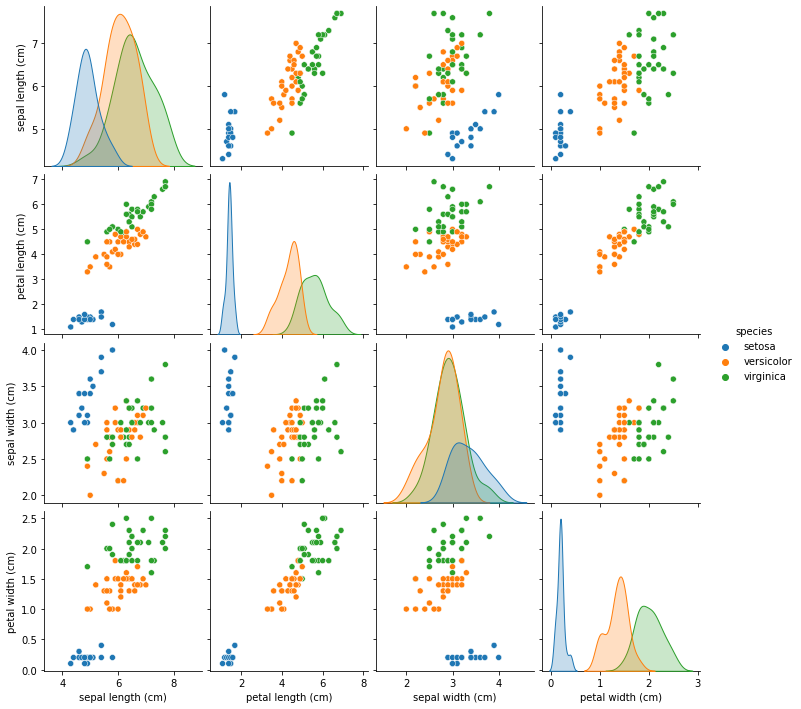

In [12]:
sns.pairplot(data = train.toPandas(), hue = 'species');

In [13]:
assembler = VectorAssembler(inputCols=['sepal length (cm)', 'petal length (cm)'], outputCol='x_vec') # scaler 적용할 column들을 벡터화
scaler = MinMaxScaler(inputCol="x_vec", outputCol="x_scaled") # minmax scaler 적용
species_indexer = StringIndexer(inputCol='species', outputCol='species_num') # dummy화 할 column index로 변경
species_encoder = OneHotEncoder(inputCol='species_num', outputCol='species_vector') # dummy화
vectorAssembler = VectorAssembler(inputCols = ['x_scaled', 'species_vector'], outputCol = 'features') # 최종 features들을 벡터화

#Create pipeline and pass all stages
pipeline = Pipeline(stages=[assembler,
                            scaler,
                            species_indexer,
                            species_encoder,
                            vectorAssembler
                            ])

In [14]:
train_transformed = pipeline.fit(train).transform(train)
train_transformed.show(5)

+----------+-----------------+-----------------+----------------+----------------+---------+--------------------+-----------+--------------+--------------------+
|   species|sepal length (cm)|petal length (cm)|sepal width (cm)|petal width (cm)|    x_vec|            x_scaled|species_num|species_vector|            features|
+----------+-----------------+-----------------+----------------+----------------+---------+--------------------+-----------+--------------+--------------------+
|    setosa|              4.4|              1.4|             2.9|             0.2|[4.4,1.4]|[0.02941176470588...|        2.0|     (2,[],[])|[0.02941176470588...|
|versicolor|              6.4|              4.5|             3.2|             1.5|[6.4,4.5]|[0.61764705882352...|        0.0| (2,[0],[1.0])|[0.61764705882352...|
| virginica|              6.2|              4.8|             2.8|             1.8|[6.2,4.8]|[0.55882352941176...|        1.0| (2,[1],[1.0])|[0.55882352941176...|
| virginica|              7.

In [15]:
test_transformed = pipeline.fit(test).transform(test)
test_transformed.show(5)

+---------+-----------------+-----------------+---------+--------------------+-----------+--------------+--------------------+
|  species|sepal length (cm)|petal length (cm)|    x_vec|            x_scaled|species_num|species_vector|            features|
+---------+-----------------+-----------------+---------+--------------------+-----------+--------------+--------------------+
|   setosa|              5.4|              1.7|[5.4,1.7]|[0.28571428571428...|        0.0| (2,[0],[1.0])|[0.28571428571428...|
|   setosa|              5.7|              1.5|[5.7,1.5]|[0.37142857142857...|        0.0| (2,[0],[1.0])|[0.37142857142857...|
|   setosa|              5.3|              1.5|[5.3,1.5]|[0.25714285714285...|        0.0| (2,[0],[1.0])|[0.25714285714285...|
|   setosa|              5.1|              1.9|[5.1,1.9]|[0.19999999999999...|        0.0| (2,[0],[1.0])|[0.19999999999999...|
|virginica|              6.0|              4.8|[6.0,4.8]|[0.45714285714285...|        2.0|     (2,[],[])|[0.457

In [23]:
train, test = train_transformed.randomSplit([0.8, 0.2])

In [24]:
lr_sepal = LinearRegression(featuresCol = 'features', labelCol = 'sepal width (cm)', maxIter=10, regParam=0.01).fit(train)
lr_petal = LinearRegression(featuresCol = 'features', labelCol = 'petal width (cm)', maxIter=10, regParam=0.01).fit(train)

In [25]:
def summary_training(model):
    trainingSummary = model.summary
    print("MAE: %f" % trainingSummary.meanAbsoluteError)
    print("r2: %f" % trainingSummary.r2)

In [26]:
summary_training(lr_sepal)

MAE: 0.216077
r2: 0.465923


In [27]:
summary_training(lr_petal)

MAE: 0.130887
r2: 0.940379


In [28]:
def evaluate_test(df, model, label, metric):
    pred = model.transform(df)
    print(RegressionEvaluator(labelCol=label, metricName=metric).evaluate(pred))

In [29]:
evaluate_test(test, lr_sepal, 'sepal width (cm)', 'mae')
evaluate_test(test, lr_petal, 'petal width (cm)', 'mae')

0.2298747079904708
0.13438800077003046


In [33]:
# submission 제출시 예상 점수
(0.2298 + 0.1343) / 2

0.18205

In [30]:
# 전체 데이터에 대해 재학습
lr_sepal = LinearRegression(featuresCol = 'features', labelCol = 'sepal width (cm)', maxIter=10, regParam=0.01).fit(train_transformed)
lr_petal = LinearRegression(featuresCol = 'features', labelCol = 'petal width (cm)', maxIter=10, regParam=0.01).fit(train_transformed)

In [31]:
summary_training(lr_sepal)

MAE: 0.218030
r2: 0.492295


In [32]:
summary_training(lr_petal)

MAE: 0.131984
r2: 0.935538
